# AutoML with Tabular data - Training Models and Ensembling 

We next focus on the training of individual models and how to combine their predictions into an ensemble that is more accurate than any of the individual models. 

**Motivating Example:** Here we assume you have some basic familiarity with the concepts of [Decision Trees](https://bradleyboehmke.github.io/HOML/DT.html) and [Random Forests](https://bradleyboehmke.github.io/HOML/random-forest.html), but this knowledge is not required for the rest of the tutorial. 
Consider the dataset shown below in panel **(A)** with 2 features (one per axis), involving a regression task with the color intensity of each datapoint indicating values of the target-variable.  If we train a decision tree model on this data, the tree splits might be selected as in **(B)**, with the resulting  regression function learned by the decision tree shown in **(C)**.

<table>
  <tr>
     <td style="text-align:center"> <img src="files/images/EnsembleExampleData.png" width="200" height="200"/> </td>
    <td style="text-align:center"> <img src="files/images/EnsembleExampleDTwData.png" width="200" height="200"/>  </td>
    <td style="text-align:center"> <img src="files/images/EnsembleExampleDT.png" width="200" height="200"/> </td>
      <td style="text-align:center"> <img src="files/images/EnsembleExampleDTensemble.png" width="200" height="200"/>  </td>
    <td style="text-align:center"> <img src="files/images/EnsembleExampleRF.png" width="200" height="200"/> </td>
  </tr>
  <tr>
      <td style="text-align:center"> (A) Dataset </td> 
      <td style="text-align:center"> (B) Decision Tree Splits </td> 
      <td style="text-align:center"> (C) Decision Tree Predictions </td> 
      <td style="text-align:center"> (D) 4 Decision Tree Models </td> 
      <td style="text-align:center"> (E) Ensemble Predictions </td> 
  </tr>
</table>

We can train multiple decision tree models as shown in **(D)**, obtaining different predictors in each training run if some randomness is introduced (eg. via: subsampling of the data used to fit each tree, or random-selection of feature in each split). If we simply average the predictions of each decision tree, the resulting ensemble-model produces predictions shown in **(E)**. Note that these ensemble predictions appear much better suited for the data from **(A)**, and such ensembling is the strategy Random Forests use to produce much higher accuracy than individual decision trees.




**Desirable Ensemble Characteristics:** Let $f_1, f_2, \dots, f_{9}$ denote 9 different trained predictors, where $f_j(x)$ is the $j$th model's prediction for a datapoint with feature-values $x$ (predicted class-probabilities in classification).  We can construct an ensemble-predictor $f_*(x) = \frac{1}{9} \sum_{j=1}^{9} f_j(x)$ by averaging the predictions of the individual models as graphically depicted in **(E)** above. 

Suppose we are doing binary classification and each individual predictor $f_j$ is extremely-confident outputting either 0 or 1 for its estimated probability that a datapoint belongs to the positive class. Assume each $f_j$ 
has error-rate = 0.3, that is, there is a 30% chance this predictor makes the wrong prediction given a new datapoint sampled from the underlying data-generating distribution.

If the predictions of $f_1, f_2, \dots, f_{9}$ are completely identical for all $x$ (i.e. these predictors make highly correlated errors), then the error-rate of $f_*$ will also obviously be 0.3 and nothing has been gained from ensembling.  At the opposite extreme, suppose these predictors make statistically independent errors. In this case, $f_*(x)$ only makes an error if at least 5 of the predictors are wrong, which happens with probability $\displaystyle = \sum_{k=5}^{9} {9 \choose k} 0.3^k (1 - 0.3)^{9-k} \le 0.1$, so the error-rate of the ensemble is far lower than the error-rate of the individual predictors.

In general, the accuracy of our ensemble will improve the more individual predictors we combine and the less-correlated their errors are. Two ways to reduce this correlation, i.e. increase the *diversity* of the ensemble, are: 

1) Train completely different types of models that tend to learn different types of functions.

2) Train different models using different subsets of the data. 

In practice, our individual predictors $f_1, f_2, \dots, f_{9}$ will have different error-rates, in which case we prefer to construct a *weighted* ensemble: $f_*(x) = \sum_{j=1}^{9} w_j f_j(x)$, where the weights $w_j$ sum to 1 and are chosen to favor the more-accurate predictors. To learn more about different ensembling strategies, see:  ([Dietterich, 2000](https://web.engr.oregonstate.edu/~tgd/publications/mcs-ensembles.pdf); [Rocca, 2019](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)).


## Training different types of models:

Let's revisit what happens in AutoGluon training by default, this time specifying `'balanced_accuracy'` as the evaluation-metric AutoGluon should optimize for, and increasing the `verbosity` to print more training details:

In [1]:
from autogluon import TabularPrediction as task
from IPython.display import display

subsample_size = 600 # experiment with larger values to try AutoGluon with larger datasets 

train_data_full = task.Dataset(file_path='https://autogluon.s3.amazonaws.com/datasets/diabetes/train.csv')
train_data = train_data_full.head(subsample_size) # subsample data for faster demo
label_column = 'readmitted'
predictor = task.fit(train_data=train_data, label=label_column, eval_metric='balanced_accuracy', verbosity=4)
test_data = task.Dataset(file_path='https://autogluon.s3.amazonaws.com/datasets/diabetes/test.csv')
test_data = test_data.head(subsample_size) # subsample data for faster demodisplay(train_data)
test_perf = predictor.leaderboard(test_data, silent=True)
print("Balanced-Accuracy of each model on test data:")
display(test_perf)

Loaded data from: https://autogluon.s3.amazonaws.com/datasets/diabetes/train.csv | Columns = 47 / 47 | Rows = 61059 -> 61059
No output_directory specified. Models will be saved in: AutogluonModels/ag-20200801_200529/
Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20200801_200529/
AutoGluon Version:  0.0.13b20200731
Train Data Rows:    600
Train Data Columns: 47
Preprocessing data ...
Here are the 3 unique label values in your data:  ['NO', '>30', '<30']
AutoGluon infers your prediction problem is: multiclass  (because dtype of label-column == object).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Train Data Class Count: 3
Feature Generator processed 600 data points with 33 features
Original Features (raw dtypes):
	object features: 25
	float64 features: 1
	int64 features: 7
Original Features (inferred dtypes):
	object features: 25
	float featur

[1]	train_set's multi_logloss: 0.89897	train_set's balanced_accuracy: 0.333333	valid_set's multi_logloss: 0.907116	valid_set's balanced_accuracy: 0.333333
[2]	train_set's multi_logloss: 0.880115	train_set's balanced_accuracy: 0.360721	valid_set's multi_logloss: 0.899548	valid_set's balanced_accuracy: 0.354444
[3]	train_set's multi_logloss: 0.861484	train_set's balanced_accuracy: 0.406287	valid_set's multi_logloss: 0.894264	valid_set's balanced_accuracy: 0.384444
[4]	train_set's multi_logloss: 0.843264	train_set's balanced_accuracy: 0.455986	valid_set's multi_logloss: 0.895379	valid_set's balanced_accuracy: 0.367778
[5]	train_set's multi_logloss: 0.825671	train_set's balanced_accuracy: 0.478297	valid_set's multi_logloss: 0.890938	valid_set's balanced_accuracy: 0.388889
[6]	train_set's multi_logloss: 0.810194	train_set's balanced_accuracy: 0.496161	valid_set's multi_logloss: 0.890804	valid_set's balanced_accuracy: 0.377778
[7]	train_set's multi_logloss: 0.793599	train_set's balanced_accu

[83]	train_set's multi_logloss: 0.253067	train_set's balanced_accuracy: 0.993546	valid_set's multi_logloss: 0.887874	valid_set's balanced_accuracy: 0.52
[84]	train_set's multi_logloss: 0.249826	train_set's balanced_accuracy: 0.993546	valid_set's multi_logloss: 0.889205	valid_set's balanced_accuracy: 0.52
[85]	train_set's multi_logloss: 0.246746	train_set's balanced_accuracy: 0.993546	valid_set's multi_logloss: 0.887566	valid_set's balanced_accuracy: 0.52
[86]	train_set's multi_logloss: 0.243321	train_set's balanced_accuracy: 0.993546	valid_set's multi_logloss: 0.889642	valid_set's balanced_accuracy: 0.513333
[87]	train_set's multi_logloss: 0.240115	train_set's balanced_accuracy: 0.993546	valid_set's multi_logloss: 0.89414	valid_set's balanced_accuracy: 0.507778
[88]	train_set's multi_logloss: 0.236816	train_set's balanced_accuracy: 0.995238	valid_set's multi_logloss: 0.892279	valid_set's balanced_accuracy: 0.507778
[89]	train_set's multi_logloss: 0.233681	train_set's balanced_accuracy:

[145]	train_set's multi_logloss: 0.118213	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.972034	valid_set's balanced_accuracy: 0.471111
[146]	train_set's multi_logloss: 0.116672	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.971669	valid_set's balanced_accuracy: 0.476667
[147]	train_set's multi_logloss: 0.115448	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.970194	valid_set's balanced_accuracy: 0.483333
[148]	train_set's multi_logloss: 0.113941	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.969214	valid_set's balanced_accuracy: 0.483333
[149]	train_set's multi_logloss: 0.112803	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.969048	valid_set's balanced_accuracy: 0.476667
[150]	train_set's multi_logloss: 0.111511	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.970554	valid_set's balanced_accuracy: 0.483333
[151]	train_set's multi_logloss: 0.110035	train_set's balanced_accuracy: 1	valid_set's multi_l

Saving AutogluonModels/ag-20200801_200529/models/LightGBMClassifier/model.pkl
	0.52	 = Validation balanced_accuracy score
	0.84s	 = Training runtime
	0.03s	 = Validation runtime
Saving AutogluonModels/ag-20200801_200529/models/trainer.pkl
Fitting model: CatboostClassifier ...


[215]	train_set's multi_logloss: 0.0537028	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.0632	valid_set's balanced_accuracy: 0.47
[216]	train_set's multi_logloss: 0.0531629	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.06127	valid_set's balanced_accuracy: 0.47
[217]	train_set's multi_logloss: 0.0525888	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.06063	valid_set's balanced_accuracy: 0.47
[218]	train_set's multi_logloss: 0.0520365	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.06212	valid_set's balanced_accuracy: 0.47
[219]	train_set's multi_logloss: 0.0514125	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.06323	valid_set's balanced_accuracy: 0.47
[220]	train_set's multi_logloss: 0.050813	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.06389	valid_set's balanced_accuracy: 0.47
[221]	train_set's multi_logloss: 0.0503173	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.0645	valid_set'

	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': <autogluon.utils.tabular.ml.models.catboost.catboost_utils.MulticlassCustomMetric object at 0x11c1170d0>}


0:	learn: 0.3682829	test: 0.3344444	best: 0.3344444 (0)	total: 109ms	remaining: 18m 14s
1:	learn: 0.3509600	test: 0.3377778	best: 0.3377778 (1)	total: 129ms	remaining: 10m 46s
2:	learn: 0.3427375	test: 0.3466667	best: 0.3466667 (2)	total: 136ms	remaining: 7m 34s
3:	learn: 0.3387241	test: 0.3400000	best: 0.3466667 (2)	total: 140ms	remaining: 5m 50s
4:	learn: 0.3401015	test: 0.3400000	best: 0.3466667 (2)	total: 147ms	remaining: 4m 54s
5:	learn: 0.3451777	test: 0.3400000	best: 0.3466667 (2)	total: 170ms	remaining: 4m 43s
6:	learn: 0.3417936	test: 0.3400000	best: 0.3466667 (2)	total: 210ms	remaining: 4m 59s
7:	learn: 0.3502538	test: 0.3333333	best: 0.3466667 (2)	total: 240ms	remaining: 4m 59s
8:	learn: 0.3502538	test: 0.3333333	best: 0.3466667 (2)	total: 246ms	remaining: 4m 32s
9:	learn: 0.3502538	test: 0.3333333	best: 0.3466667 (2)	total: 261ms	remaining: 4m 20s
10:	learn: 0.3519459	test: 0.3333333	best: 0.3466667 (2)	total: 290ms	remaining: 4m 23s
11:	learn: 0.3539525	test: 0.3333333	bes

94:	learn: 0.6235242	test: 0.3955556	best: 0.3966667 (87)	total: 3s	remaining: 5m 13s
95:	learn: 0.6167716	test: 0.3955556	best: 0.3966667 (87)	total: 3.04s	remaining: 5m 13s
96:	learn: 0.6184636	test: 0.3966667	best: 0.3966667 (87)	total: 3.07s	remaining: 5m 13s
97:	learn: 0.6252163	test: 0.4077778	best: 0.4077778 (97)	total: 3.1s	remaining: 5m 13s
98:	learn: 0.6333464	test: 0.3966667	best: 0.4077778 (97)	total: 3.13s	remaining: 5m 13s
99:	learn: 0.6364158	test: 0.3955556	best: 0.4077778 (97)	total: 3.17s	remaining: 5m 13s
100:	learn: 0.6397999	test: 0.3877778	best: 0.4077778 (97)	total: 3.2s	remaining: 5m 14s
101:	learn: 0.6401146	test: 0.3888889	best: 0.4077778 (97)	total: 3.24s	remaining: 5m 14s
102:	learn: 0.6401146	test: 0.3944444	best: 0.4077778 (97)	total: 3.29s	remaining: 5m 16s
103:	learn: 0.6418066	test: 0.4011111	best: 0.4077778 (97)	total: 3.33s	remaining: 5m 17s
104:	learn: 0.6434986	test: 0.4077778	best: 0.4077778 (97)	total: 3.37s	remaining: 5m 17s
105:	learn: 0.6431840

186:	learn: 0.8685103	test: 0.4033333	best: 0.4088889 (106)	total: 6.17s	remaining: 5m 23s
187:	learn: 0.8780177	test: 0.4100000	best: 0.4100000 (187)	total: 6.19s	remaining: 5m 23s
188:	learn: 0.8780177	test: 0.4033333	best: 0.4100000 (187)	total: 6.23s	remaining: 5m 23s
189:	learn: 0.8780177	test: 0.3966667	best: 0.4100000 (187)	total: 6.25s	remaining: 5m 22s
190:	learn: 0.8763257	test: 0.3966667	best: 0.4100000 (187)	total: 6.28s	remaining: 5m 22s
191:	learn: 0.8780177	test: 0.3966667	best: 0.4100000 (187)	total: 6.32s	remaining: 5m 22s
192:	learn: 0.8746336	test: 0.4033333	best: 0.4100000 (187)	total: 6.35s	remaining: 5m 22s
193:	learn: 0.8746336	test: 0.3922222	best: 0.4100000 (187)	total: 6.39s	remaining: 5m 22s
194:	learn: 0.8763257	test: 0.3988889	best: 0.4100000 (187)	total: 6.41s	remaining: 5m 22s
195:	learn: 0.8763257	test: 0.4044444	best: 0.4100000 (187)	total: 6.44s	remaining: 5m 22s
196:	learn: 0.8780177	test: 0.4177778	best: 0.4177778 (196)	total: 6.49s	remaining: 5m 22s

279:	learn: 0.9820478	test: 0.4222222	best: 0.4366667 (216)	total: 9.72s	remaining: 5m 37s
280:	learn: 0.9820478	test: 0.4222222	best: 0.4366667 (216)	total: 9.75s	remaining: 5m 37s
281:	learn: 0.9820478	test: 0.4222222	best: 0.4366667 (216)	total: 9.78s	remaining: 5m 36s
282:	learn: 0.9820478	test: 0.4222222	best: 0.4366667 (216)	total: 9.81s	remaining: 5m 36s
283:	learn: 0.9820478	test: 0.4166667	best: 0.4366667 (216)	total: 9.84s	remaining: 5m 36s
284:	learn: 0.9820478	test: 0.4166667	best: 0.4366667 (216)	total: 9.87s	remaining: 5m 36s
285:	learn: 0.9820478	test: 0.4222222	best: 0.4366667 (216)	total: 9.92s	remaining: 5m 36s
286:	learn: 0.9820478	test: 0.4222222	best: 0.4366667 (216)	total: 9.96s	remaining: 5m 37s
287:	learn: 0.9820478	test: 0.4222222	best: 0.4366667 (216)	total: 10s	remaining: 5m 37s
288:	learn: 0.9820478	test: 0.4155556	best: 0.4366667 (216)	total: 10s	remaining: 5m 36s
289:	learn: 0.9820478	test: 0.4155556	best: 0.4366667 (216)	total: 10.1s	remaining: 5m 36s
290

372:	learn: 1.0000000	test: 0.4444444	best: 0.4444444 (365)	total: 13.1s	remaining: 5m 38s
373:	learn: 1.0000000	test: 0.4444444	best: 0.4444444 (365)	total: 13.1s	remaining: 5m 38s
374:	learn: 1.0000000	test: 0.4444444	best: 0.4444444 (365)	total: 13.2s	remaining: 5m 38s
375:	learn: 1.0000000	test: 0.4377778	best: 0.4444444 (365)	total: 13.2s	remaining: 5m 37s
376:	learn: 1.0000000	test: 0.4322222	best: 0.4444444 (365)	total: 13.2s	remaining: 5m 37s
377:	learn: 1.0000000	test: 0.4322222	best: 0.4444444 (365)	total: 13.2s	remaining: 5m 37s
378:	learn: 1.0000000	test: 0.4322222	best: 0.4444444 (365)	total: 13.3s	remaining: 5m 37s
379:	learn: 1.0000000	test: 0.4255556	best: 0.4444444 (365)	total: 13.3s	remaining: 5m 36s
380:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 13.3s	remaining: 5m 36s
381:	learn: 1.0000000	test: 0.4377778	best: 0.4444444 (365)	total: 13.4s	remaining: 5m 37s
382:	learn: 1.0000000	test: 0.4322222	best: 0.4444444 (365)	total: 13.5s	remaining: 5m 38s

463:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.2s	remaining: 5m 33s
464:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.2s	remaining: 5m 33s
465:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.3s	remaining: 5m 32s
466:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.3s	remaining: 5m 32s
467:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.3s	remaining: 5m 32s
468:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.3s	remaining: 5m 32s
469:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.4s	remaining: 5m 32s
470:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.4s	remaining: 5m 31s
471:	learn: 1.0000000	test: 0.4366667	best: 0.4444444 (365)	total: 16.4s	remaining: 5m 31s
472:	learn: 1.0000000	test: 0.4366667	best: 0.4444444 (365)	total: 16.5s	remaining: 5m 31s
473:	learn: 1.0000000	test: 0.4311111	best: 0.4444444 (365)	total: 16.5s	remaining: 5m 31s

Saving AutogluonModels/ag-20200801_200529/models/CatboostClassifier/model.pkl
	0.4444	 = Validation balanced_accuracy score
	18.07s	 = Training runtime
	0.03s	 = Validation runtime
Saving AutogluonModels/ag-20200801_200529/models/trainer.pkl


511:	learn: 1.0000000	test: 0.4433333	best: 0.4444444 (365)	total: 17.7s	remaining: 5m 28s
512:	learn: 1.0000000	test: 0.4366667	best: 0.4444444 (365)	total: 17.8s	remaining: 5m 28s
513:	learn: 1.0000000	test: 0.4433333	best: 0.4444444 (365)	total: 17.8s	remaining: 5m 28s
514:	learn: 1.0000000	test: 0.4433333	best: 0.4444444 (365)	total: 17.8s	remaining: 5m 28s
515:	learn: 1.0000000	test: 0.4433333	best: 0.4444444 (365)	total: 17.9s	remaining: 5m 28s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.4444444444
bestIteration = 365

Shrink model to first 366 iterations.


Fitting model: NeuralNetClassifier ...
AutoGluon Neural Network infers features are of the following types:
{
    "continuous": [
        "time_in_hospital",
        "num_lab_procedures",
        "num_procedures",
        "number_diagnoses"
    ],
    "skewed": [
        "num_medications",
        "number_outpatient",
        "number_inpatient"
    ],
    "onehot": [
        "number_emergency",
        "gender",
        "metformin",
        "tolbutamide",
        "pioglitazone",
        "rosiglitazone",
        "acarbose",
        "troglitazone",
        "tolazamide",
        "change",
        "diabetesMed"
    ],
    "embed": [
        "age",
        "admission_type_id",
        "discharge_disposition_id",
        "admission_source_id",
        "medical_specialty",
        "diag_1",
        "diag_2",
        "diag_3",
        "max_glu_serum",
        "A1Cresult",
        "repaglinide",
        "glimepiride",
        "glipizide",
        "glyburide",
        "insulin"
    ],
    "langu

[1]	train_set's multi_logloss: 0.893412	train_set's balanced_accuracy: 0.333333	valid_set's multi_logloss: 0.915573	valid_set's balanced_accuracy: 0.333333
[2]	train_set's multi_logloss: 0.866556	train_set's balanced_accuracy: 0.333333	valid_set's multi_logloss: 0.911246	valid_set's balanced_accuracy: 0.333333
[3]	train_set's multi_logloss: 0.840547	train_set's balanced_accuracy: 0.333333	valid_set's multi_logloss: 0.908139	valid_set's balanced_accuracy: 0.333333
[4]	train_set's multi_logloss: 0.815812	train_set's balanced_accuracy: 0.439932	valid_set's multi_logloss: 0.90058	valid_set's balanced_accuracy: 0.346667
[5]	train_set's multi_logloss: 0.792856	train_set's balanced_accuracy: 0.548223	valid_set's multi_logloss: 0.898482	valid_set's balanced_accuracy: 0.347778
[6]	train_set's multi_logloss: 0.770575	train_set's balanced_accuracy: 0.598985	valid_set's multi_logloss: 0.896211	valid_set's balanced_accuracy: 0.355556
[7]	train_set's multi_logloss: 0.749238	train_set's balanced_accu

[69]	train_set's multi_logloss: 0.168251	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.882719	valid_set's balanced_accuracy: 0.405556
[70]	train_set's multi_logloss: 0.164613	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.883237	valid_set's balanced_accuracy: 0.412222
[71]	train_set's multi_logloss: 0.160898	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.884243	valid_set's balanced_accuracy: 0.406667
[72]	train_set's multi_logloss: 0.157341	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.885666	valid_set's balanced_accuracy: 0.395556
[73]	train_set's multi_logloss: 0.153809	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.886188	valid_set's balanced_accuracy: 0.395556
[74]	train_set's multi_logloss: 0.150394	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.887558	valid_set's balanced_accuracy: 0.401111
[75]	train_set's multi_logloss: 0.147107	train_set's balanced_accuracy: 1	valid_set's multi_logloss:

[144]	train_set's multi_logloss: 0.033143	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.961334	valid_set's balanced_accuracy: 0.401111
[145]	train_set's multi_logloss: 0.0324355	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.963896	valid_set's balanced_accuracy: 0.401111
[146]	train_set's multi_logloss: 0.0317347	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.966543	valid_set's balanced_accuracy: 0.401111
[147]	train_set's multi_logloss: 0.0310618	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.968376	valid_set's balanced_accuracy: 0.394444
[148]	train_set's multi_logloss: 0.0304463	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.971089	valid_set's balanced_accuracy: 0.394444
[149]	train_set's multi_logloss: 0.0298484	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 0.973238	valid_set's balanced_accuracy: 0.394444
[150]	train_set's multi_logloss: 0.0292281	train_set's balanced_accuracy: 1	valid_set's m

Saving AutogluonModels/ag-20200801_200529/models/LightGBMClassifierCustom/model.pkl


[190]	train_set's multi_logloss: 0.0126536	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.06784	valid_set's balanced_accuracy: 0.382222
[191]	train_set's multi_logloss: 0.0123947	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.0708	valid_set's balanced_accuracy: 0.382222
[192]	train_set's multi_logloss: 0.0121585	train_set's balanced_accuracy: 1	valid_set's multi_logloss: 1.07271	valid_set's balanced_accuracy: 0.382222


	0.4467	 = Validation balanced_accuracy score
	2.04s	 = Training runtime
	0.04s	 = Validation runtime
Saving AutogluonModels/ag-20200801_200529/models/trainer.pkl
Loading: AutogluonModels/ag-20200801_200529/models/RandomForestClassifierGini/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/RandomForestClassifierEntr/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/ExtraTreesClassifierGini/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/ExtraTreesClassifierEntr/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/KNeighborsClassifierUnif/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/KNeighborsClassifierDist/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/LightGBMClassifier/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/CatboostClassifier/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/NeuralNetClassifier/model.pkl
Loading: AutogluonModels/ag-20200801_200529/models/LightGBMClassifierCustom/

Balanced-Accuracy of each model on test data:


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer
0,ExtraTreesClassifierGini,0.402109,0.441111,0.158669,0.126700,0.547868,0.158669,0.126700,0.547868,0,True
1,ExtraTreesClassifierEntr,0.393565,0.460000,0.152231,0.136706,0.543493,0.152231,0.136706,0.543493,0,True
2,LightGBMClassifier,0.376044,0.520000,0.045882,0.027615,0.840943,0.045882,0.027615,0.840943,0,True
3,RandomForestClassifierGini,0.373715,0.431111,0.165529,0.130083,0.698699,0.165529,0.130083,0.698699,0,True
4,weighted_ensemble_k0_l1,0.371436,0.522222,0.204413,0.165672,2.073096,0.006300,0.001351,0.688660,1,True
5,CatboostClassifier,0.365745,0.444444,0.031150,0.029343,18.074721,0.031150,0.029343,18.074721,0,True
6,RandomForestClassifierEntr,0.353483,0.442222,0.146133,0.130906,0.645182,0.146133,0.130906,0.645182,0,True
7,NeuralNetClassifier,0.349055,0.340000,0.191691,0.050880,4.979828,0.191691,0.050880,4.979828,0,True
8,LightGBMClassifierCustom,0.340253,0.446667,0.044743,0.041768,2.043933,0.044743,0.041768,2.043933,0,True
9,KNeighborsClassifierDist,0.328902,0.410000,0.111893,0.109032,0.005723,0.111893,0.109032,0.005723,0,True


Here we can see the fine-grained performance of iteratively-trained models during their learning process. Within the call to `fit()`, AutoGluon trained many types of models:

- **RandomForestClassifierGini**: Random Forest with [Gini criterion](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) used to select splits in each tree.

- **RandomForestClassifierEntr**: Random Forest with [Entropy criterion](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) used to select splits in each tree.

- **ExtraTreesClassifierGini**: Extremely-Randomized Trees with [Gini criterion](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) used to select splits in each tree.

- **ExtraTreesClassifierEntr**: Extremely-Randomized Trees with [Entropy criterion](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) used to select splits in each tree.

- **KNeighborsClassifierUnif**: K Nearest Neighbors (KNN) with [uniform weights](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) used to combine labels of nearest-neighbors into prediction.

- **KNeighborsClassifierDist**: K Nearest Neighbors with [distance-based weights](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) used to combine labels of nearest-neighbors into prediction.

- **LightGBMClassifier**: [LightGBM](https://lightgbm.readthedocs.io/en/latest/) gradient boosted trees with mostly default hyperparameter settings.

- **LightGBMClassifierCustom**: [LightGBM](https://lightgbm.readthedocs.io/en/latest/) gradient boosted trees with [custom hyperparameters](https://github.com/awslabs/autogluon/blob/master/autogluon/utils/tabular/ml/models/lgb/hyperparameters/parameters.py) that favor a larger number of larger and more-diverse trees.  

- **CatboostClassifier**: [Catboost](https://catboost.ai/) gradient boosted trees.

- **NeuralNetClassifier**: Neural network model (implemented in MXNet) whose architecture is printed in the logs above.  

Note that traditional ML projects (and many AutoML tools) would treat items like the tree split-criterion or KNN-weighting as decisions/hyperparameters to be optimized. In contrast, AutoGluon simply trains separate models with all options as individual predictors for the weighted ensemble (which increases its diversity). For detailed descriptions of each model type, see: ([Boehmke, 2020: Chapters 8-13](https://bradleyboehmke.github.io/HOML/)).

We briefly highlight some properties of certain model types:

- LightGBM/CatBoost (and the similar but older XGBoost) are currently the most popular models for tabular data, [almost always used by top Kaggle competitors](https://towardsdatascience.com/four-ways-teams-win-on-kaggle-50e62acb87f4).  [LightGBM](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree) is one of the fastest gradient-boosting implementations, whereas [CatBoost](https://papers.nips.cc/paper/7898-catboost-unbiased-boosting-with-categorical-features.pdf) offers sophisticated handling of categorical features and is more resilient to overfitting through careful regularization.

- Random Forests and Extremely Randomized Trees tend to be robustly performant regardless of their hyperparameter-settings, fast-to-train, but are generally not as accurate as gradient-boosted trees except for smaller datasets. For large datasets, these models can produce undesirably large model files when their maximum tree-depth is uncapped (which usually helps improve their accuracy).

- The Neural Network is described in detail in the [**AutoGluon-Tabular** paper](https://arxiv.org/abs/2003.06505), and utilizes [learned embeddings of categorical features](https://arxiv.org/abs/1604.06737), [shortcut-connections](https://arxiv.org/abs/1606.07792), and fully-connected layers with [ReLU activations](https://www.cs.toronto.edu/~fritz/absps/reluICML.pdf), [batch-normalization](https://arxiv.org/abs/1502.03167) and [dropout regularization](http://jmlr.org/papers/v15/srivastava14a.html). These neural networks tend to be among the better models for tabular datasets with many samples, but are often less accurate for datasets with fewer samples or a vast number of features.

- K Nearest Neighbors is fast-to-train but slow-for-inference, and typically the least accurate model-type in AutoGluon. Exceptions where KNN outperforms the other model-types include geospatial datasets or simple prediction tasks which can be solved by memorizing the training data.

- Even when they are not the most accurate models on a particular dataset, the neural network and KNN model play a key role in AutoGluon. As the rest of the models are all trees, their decision boundaries are sharp and axis-aligned. In constrast, the KNN/neural-network decision boundaries are often far smoother with relatively unconstrained geometry. These models thus provide valuable diversity to the AutoGluon ensemble.

<table> 
    <caption> Decision boundary of fitted models of various types in 3 binary classification tasks: </caption>
  <tr>
     <td style="text-align:center"> <img src="files/images/decisionboundary-input.png" width="100" height="100"/> </td>
    <td style="text-align:center"> <img src="files/images/decisionboundary-rf.png" width="100" height="100"/>  </td>
    <td style="text-align:center"> <img src="files/images/decisionboundary-nn.png" width="100" height="100"/> </td>
      <td style="text-align:center"> <img src="files/images/decisionboundary-knn.png" width="100" height="100"/>  </td>
  </tr>
</table>



Inside the `fit()` call above, AutoGluon performed a random (stratified) split of the data into training and validation sets. A model of each type was trained on the training data (preceded by some model-specific preprocessing applied to a copy of this data passed to the model), and subsequently asked to produce predictions on the validation data. Finally, AutoGluon constructed a weighted ensemble that aggregates the predictions of the individual models in a weighted manner.  Let's take a closer look at this model ensemble:

In [2]:
ensemble = predictor._trainer.load_model('weighted_ensemble_k0_l1')
display(ensemble.get_info())

Loading: AutogluonModels/ag-20200801_200529/models/weighted_ensemble_k0_l1/model.pkl


{'name': 'weighted_ensemble_k0_l1',
 'model_type': 'WeightedEnsembleModel',
 'problem_type': 'multiclass',
 'eval_metric': 'balanced_accuracy',
 'stopping_metric': 'balanced_accuracy',
 'fit_time': 0.6886599063873291,
 'predict_time': 0.0013511180877685547,
 'val_score': 0.5222222222222223,
 'hyperparameters': {'max_models': 25, 'max_models_per_type': 5},
 'hyperparameters_fit': {},
 'hyperparameters_nondefault': [],
 'memory_size': 9055,
 'bagged_info': {'child_type': 'GreedyWeightedEnsembleModel',
  'num_child_models': 1,
  'child_model_names': ['greedy_ensemble'],
  '_n_repeats': 1,
  '_k_per_n_repeat': [1],
  '_random_state': 1,
  'low_memory': False,
  'bagged_mode': False,
  'max_memory_size': 9055,
  'min_memory_size': 9055},
 'stacker_info': {'num_base_models': 2,
  'base_model_names': ['LightGBMClassifier', 'ExtraTreesClassifierEntr'],
  'use_orig_features': False},
 'children_info': {'greedy_ensemble': {'name': 'greedy_ensemble',
   'model_type': 'GreedyWeightedEnsembleModel'

The `'model_weights'` attribute shows that this ensemble only considers the predictions of some individual models  (all other model-types received weight 0 meaning their predictions are ignored). From `'model_type'`, we see this ensemble is of type `GreedyWeightedEnsembleModel`.

For this type of ensemble, the weights are selected via the [Ensemble-Selection algorithm of Caruana et al. (2004)](https://www.cs.cornell.edu/~alexn/papers/shotgun.icml04.revised.rev2.pdf), which is also utilized by some other AutoML tools like [auto-sklearn](https://automl.github.io/auto-sklearn/master/).  The ensemble selection procedure simply uses greedy forward selection to choose the model-weights:

0. Initialize the ensemble so all models start with weight = 0.
1. Consider adding each model to current weighted ensemble (with weight = 1 if this model is not in current ensemble, otherwise increment its weight += 1)

2. Only actually add whichever model contributed the most to ensemble performance on the validation data. The ensemble is evaluated according to the specified evaluation-metric (balanced-accuracy for this particular AutoGluon run), with the current model-weights normalized to sum to 1 when combining model-predictions.

3. Repeatedly iterate (1)-(2), where models may be chosen again even if added in previous rounds.
4. Stop when no more additions can further boost the current ensemble's validation performance.

This runs extremely efficiently if we've cached all the predictions of individual models on the validation data.  Because the weights of the ensemble were adaptively selected based on the validation data, be aware that the resulting validation-score of the WeightedEnsemble tends to be more overfit than the individual models' validation-scores.  Nonetheless, this crude procedure for selecting the weights is nice because it:
- can be applied with any evaluation-metric (regardless if differentiable/continuous)
- produces sparse weights which reduce the ensemble-size
- remains more resilient to overfitting than some weighting strategies such as continuous-optimization to find  weights that are globally optimal with respect to validation-score (eg. via regression modeling).

## Stack Ensembling

Stack ensembling is another powerful ensembling technique to additionally grow ensembles and further boost their predictive accuracy ([van Veen et al, 2015](https://mlwave.com/kaggle-ensembling-guide/); [Wolpert, 1992](https://www.sciencedirect.com/science/article/abs/pii/S0893608005800231); [Polley & Van der Laan, 2010](https://biostats.bepress.com/cgi/viewcontent.cgi?article=1269&context=ucbbiostat)). The previously discussed weighted-ensemble combines the predictions of individual models via a simple linear combination, but why should this be the optimal method?

In stacking, one instead trains another 'stacker' ML model that takes in the predictions of the individual 'base' models and learns how they should be best combined. This can be achieved simply by training the stacker model on a newly constructed dataset where the features are now all of the base-model predictions (concatenated together, using predicted class-probabilities in classification), and the target-values remain the same as in the original prediction task. The stacker model can rectify shortcomings of the individual base predictions and exploit interactions between them that offer enhanced predictive power ([Van der Laan et al, 2007](https://biostats.bepress.com/cgi/viewcontent.cgi?article=1226&context=ucbbiostat)). But how do we know what type of model the stacker should be?

Since we don't know, we can train multiple types of stacker models (just like AutoGluon originally trained multiple types of base models on the original data features). We can once again aggregate these stacker models' predictions via a weighted-ensemble, or we can add another layer of stacker models on top of them. *Multi-layer stacking* feeds the predictions output by the stacker models as inputs to additional higher layer stacker models. Iterating this process in multiple layers has been a winning strategy in prominent prediction competitions ([Koren, 2009](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf); [Titericz & Semenov, 2016](https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335)). The particular form of multi-layer stacking used in AutoGluon is shown below, using two stacking layers and $n$ types of base model-types.

<img src="files/images/multistack.png" width="400" height="400">

By default (when stacking is specified), each stacking layer in AutoGluon simply employs the same model-types (and hyperparameter-values) as the base models trained in the above `fit()`.  AutoGluon stacker models take as input not only the predictions of the models at the previous layer, but also the original data features themselves (inputs to stackers are data features concatenated with lower-layer model predictions). The final stacking layer remains a simple weighted ensemble with weights chosen via Ensemble-Selection as described above.

## Bagging

It is crucial that in `fit()`, stacker models only operate on predictions from base models for datapoints held-out during the base model's training. Otherwise there could be catastrophic overfitting, since the base model could memorize a target-value from the training data and pass this as an input feature to the stacker model.
However, using only the validation data for learning the stacker models means these models receive little data, and quickly becomes untenable for stack ensembles with more layers.

Instead, AutoGluon can utilize *bagging* (short for "bootstrap aggregation") to ensure stacker models are only trained on data held-out from lower layer models, while still being able to learn from the full dataset ([Breiman 1994](https://www.stat.berkeley.edu/~breiman/bagging.pdf); [Breiman 1996](https://statistics.berkeley.edu/sites/default/files/tech-reports/367.pdf)). 
$k$-fold bagging is a simple ensemble method that reduces variance in the ensemble's resulting predictions. This is achieved by randomly partitioning the data into $k$ disjoint chunks (we stratify based on labels), and subsequently training $k$ different copies of a model with a different data chunk held-out from each copy. AutoGluon bags all models and each model is asked to produce out-of-fold (OOF) predictions on the chunk it did not see during training. As every  datapoint is OOF for one of the bagged model copies, this allows us to obtain OOF predictions from every model for every training example.

<img src="files/images/bagging.png" width="400" height="400">

In the above data-partioning scheme, we would train one Neural Network for every train/validation split, one Catboost model for every split, etc. (so in total there are $k$ Neural Networks, $k$ Catboost models, etc). We call these $k$ differently-trained copies of the same model-type a *model bag*.

At inference-time, new datapoints count as OOF for every model in a $k$-fold bagged ensemble. For a test datapoint, we simply average the predictions of each model in the bag and feed the resulting output into higher-layer stacker models. However there is a subtle train/test mismatch as the input features to stacker models are slightly noisier at training-time than at inference-time. This is because in training, stacker inputs are predictions from a *single* model in the bag, whereas at inference, stacker inputs are averaged predictions across all models in the bag. 

To mitigate this mismatch, AutoGluon uses *repeated* $k$-fold bagging, in which multiple (randomly chosen) sets of $k$-fold data-partitions and model-bags are maintained. With repeated bagging of multiple $k$-fold bags, each datapoint is remains OOF for 1 model in each $k$-fold bag, meaning we can average the predictions over the multiple models for which this datapoint is OOF even during training. With repeated bagging, we still average predictions over many more models during inference than during training. If we repeat the bagging $n$ times, the stacker input feature variance is $O(n^{-1})$ during training vs. $O((nk)^{-1})$ during inference; without repeated bagging these variances are $O(1)$ vs. $O(k^{-1})$, which is a far greater difference.

With multi-layer stacking, AutoGluon's overall training strategy is described in the following algorithm:

<img src="files/images/trainingalgorithm.png" width="400" height="400">

To produce predictions for obtaining a validation-score, the final set of $\{ \hat{Y}_m \}_{m \in \mathcal{M}}$ are combined via a weighted average, with weights chosen via Ensemble-Selection. AutoGluon selects $n$, the number of bagging repeats, based on how much time remains in the user-specified limit after the first round of $k$-fold bagging. If an overall time-limit $T$ is imposed on training, then AutoGluon allows each stacking layer to run for time $T/L$, where $L$ is the number of layers (typically $L=2$ works well in practice). The alloted runtime for training each particular model in a bagging-fold of a stack-layer is divided equally between model-types; model-types that fail to (partially) train within this time are skipped and omitted from the resulting predictor.

This design makes the framework highly predictable in its behavior: both the time envelope and failure behavior are well-specified. This approach guarantees that AutoGluon can produce predictions as long as we can train at least one model on one bagging-fold within the allotted time. As we checkpoint intermediate iterations of sequentially-trained models like neural networks and boosted trees, AutoGluon can still produce a model under meager time limits. We additionally anticipate that models may fail while training and just skip to the next model in this event.

In AutoGluon, you can optionally specify via the following [arguments to `fit()`](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.TabularPrediction.fit):

-`num_bagging_folds`: number of bagging folds ($k$ above)

-`num_bagging_sets`: number of repeated runs of $k$-fold bagging ($n$ above)

-`stack_ensemble_levels`: number of stack layers ($L$ above)

However, we recommend users that wish to maximize predictive accuracy via multi-layer stacking instead do the following:

In [3]:
train_data = train_data_full.head(1000)  # need more data to demonstrate automated-stacking
predictor_stack = task.fit(train_data=train_data, label=label_column, auto_stack=True, verbosity=3, 
                           time_limits=120)  # try increasing time_limits to see repeated-bagging in action

No output_directory specified. Models will be saved in: AutogluonModels/ag-20200801_200607/
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to AutogluonModels/ag-20200801_200607/
AutoGluon Version:  0.0.13b20200731
Train Data Rows:    1000
Train Data Columns: 47
Preprocessing data ...
Here are the 3 unique label values in your data:  ['NO', '>30', '<30']
AutoGluon infers your prediction problem is: multiclass  (because dtype of label-column == object).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Train Data Class Count: 3
Feature Generator processed 1000 data points with 33 features
Original Features (raw dtypes):
	object features: 25
	float64 features: 1
	int64 features: 7
Original Features (inferred dtypes):
	object features: 25
	float features: 1
	int features: 7
Generated Features (special dtypes):
Processed Features (raw dtypes):
	float featu

[50]	train_set's multi_error: 0.0244444	valid_set's multi_error: 0.52
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.52


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[150]	train_set's multi_error: 0	valid_set's multi_error: 0.57
[50]	train_set's multi_error: 0.0177778	valid_set's multi_error: 0.45
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.45
[150]	train_set's multi_error: 0	valid_set's multi_error: 0.46
[200]	train_set's multi_error: 0	valid_set's multi_error: 0.47


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0.0288889	valid_set's multi_error: 0.45
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.43


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[150]	train_set's multi_error: 0	valid_set's multi_error: 0.44
[50]	train_set's multi_error: 0.0233333	valid_set's multi_error: 0.43
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.42


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[150]	train_set's multi_error: 0	valid_set's multi_error: 0.4
[50]	train_set's multi_error: 0.02	valid_set's multi_error: 0.52
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.48
[150]	train_set's multi_error: 0	valid_set's multi_error: 0.48


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0.02	valid_set's multi_error: 0.37
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.36
[150]	train_set's multi_error: 0	valid_set's multi_error: 0.4
[200]	train_set's multi_error: 0	valid_set's multi_error: 0.38


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0.0155556	valid_set's multi_error: 0.52
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.5
[150]	train_set's multi_error: 0	valid_set's multi_error: 0.52


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0.0166667	valid_set's multi_error: 0.49
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.46


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[150]	train_set's multi_error: 0	valid_set's multi_error: 0.48
[50]	train_set's multi_error: 0.0188889	valid_set's multi_error: 0.46
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.47


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[150]	train_set's multi_error: 0	valid_set's multi_error: 0.45
[50]	train_set's multi_error: 0.02	valid_set's multi_error: 0.5
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.49
[150]	train_set's multi_error: 0	valid_set's multi_error: 0.49


Saving AutogluonModels/ag-20200801_200607/models/LightGBMClassifier_STACKER_l0/utils/oof.pkl
Saving AutogluonModels/ag-20200801_200607/models/LightGBMClassifier_STACKER_l0/model.pkl
	0.585	 = Validation accuracy score
	5.59s	 = Training runtime
	0.3s	 = Validation runtime
Saving AutogluonModels/ag-20200801_200607/models/trainer.pkl
Fitting model: CatboostClassifier_STACKER_l0 ... Training model for up to 15.78s of the 75.71s of remaining time.
Saving AutogluonModels/ag-20200801_200607/models/CatboostClassifier_STACKER_l0/utils/model_template.pkl
	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


0:	learn: 0.4922222	test: 0.5000000	best: 0.5000000 (0)	total: 23.1ms	remaining: 1.13s
20:	learn: 0.5733333	test: 0.6000000	best: 0.6200000 (13)	total: 195ms	remaining: 270ms
40:	learn: 0.6033333	test: 0.5900000	best: 0.6200000 (13)	total: 378ms	remaining: 82.9ms
49:	learn: 0.6200000	test: 0.6200000	best: 0.6400000 (46)	total: 463ms	remaining: 0us

bestTest = 0.64
bestIteration = 46

Shrink model to first 47 iterations.
0:	learn: 0.5977778	test: 0.6500000	best: 0.6500000 (0)	total: 6.55ms	remaining: 485ms
20:	learn: 0.6222222	test: 0.6200000	best: 0.6500000 (0)	total: 233ms	remaining: 599ms
40:	learn: 0.6511111	test: 0.6100000	best: 0.6500000 (0)	total: 444ms	remaining: 368ms
60:	learn: 0.6877778	test: 0.6000000	best: 0.6500000 (0)	total: 686ms	remaining: 157ms
74:	learn: 0.7022222	test: 0.6200000	best: 0.6500000 (0)	total: 873ms	remaining: 0us

bestTest = 0.65
bestIteration = 0



	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


0:	learn: 0.5177778	test: 0.5600000	best: 0.5600000 (0)	total: 10.2ms	remaining: 501ms
20:	learn: 0.5733333	test: 0.5600000	best: 0.5600000 (0)	total: 211ms	remaining: 292ms
40:	learn: 0.6188889	test: 0.5100000	best: 0.5600000 (0)	total: 411ms	remaining: 90.2ms
49:	learn: 0.6455556	test: 0.5300000	best: 0.5600000 (0)	total: 502ms	remaining: 0us

bestTest = 0.56
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 0.5111111	test: 0.5600000	best: 0.5600000 (0)	total: 6.59ms	remaining: 442ms
20:	learn: 0.5977778	test: 0.5900000	best: 0.5900000 (20)	total: 183ms	remaining: 410ms
40:	learn: 0.6333333	test: 0.5700000	best: 0.5900000 (20)	total: 433ms	remaining: 285ms


	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


60:	learn: 0.6700000	test: 0.5500000	best: 0.5900000 (20)	total: 673ms	remaining: 77.2ms
67:	learn: 0.6855556	test: 0.5600000	best: 0.5900000 (20)	total: 752ms	remaining: 0us

bestTest = 0.59
bestIteration = 20

0:	learn: 0.5122222	test: 0.5200000	best: 0.5200000 (0)	total: 10.2ms	remaining: 499ms
20:	learn: 0.5900000	test: 0.4900000	best: 0.5400000 (3)	total: 239ms	remaining: 331ms
40:	learn: 0.6088889	test: 0.5200000	best: 0.5400000 (3)	total: 480ms	remaining: 105ms
49:	learn: 0.6111111	test: 0.5100000	best: 0.5400000 (3)	total: 610ms	remaining: 0us

bestTest = 0.54
bestIteration = 3

Shrink model to first 4 iterations.
0:	learn: 0.5311111	test: 0.5200000	best: 0.5200000 (0)	total: 6.85ms	remaining: 336ms
20:	learn: 0.6088889	test: 0.5600000	best: 0.5600000 (20)	total: 246ms	remaining: 339ms
40:	learn: 0.6255556	test: 0.5400000	best: 0.5600000 (20)	total: 514ms	remaining: 113ms
49:	learn: 0.6466667	test: 0.5500000	best: 0.5600000 (20)	total: 629ms	remaining: 0us

bestTest = 0.56
best

	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


0:	learn: 0.5211111	test: 0.5000000	best: 0.5000000 (0)	total: 18.7ms	remaining: 915ms
20:	learn: 0.5744444	test: 0.5200000	best: 0.5200000 (2)	total: 245ms	remaining: 339ms
40:	learn: 0.6166667	test: 0.5200000	best: 0.5400000 (22)	total: 481ms	remaining: 106ms
49:	learn: 0.6311111	test: 0.5200000	best: 0.5400000 (22)	total: 588ms	remaining: 0us

bestTest = 0.54
bestIteration = 22

Shrink model to first 23 iterations.
0:	learn: 0.5744444	test: 0.5300000	best: 0.5300000 (0)	total: 7.09ms	remaining: 383ms
20:	learn: 0.6077778	test: 0.5200000	best: 0.5300000 (0)	total: 234ms	remaining: 379ms
40:	learn: 0.6300000	test: 0.5400000	best: 0.5600000 (35)	total: 490ms	remaining: 167ms
54:	learn: 0.6488889	test: 0.5500000	best: 0.5600000 (35)	total: 638ms	remaining: 0us

bestTest = 0.56
bestIteration = 35



	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


0:	learn: 0.4977778	test: 0.4700000	best: 0.4700000 (0)	total: 12ms	remaining: 588ms
20:	learn: 0.5888889	test: 0.5700000	best: 0.6000000 (16)	total: 181ms	remaining: 250ms
40:	learn: 0.6255556	test: 0.5400000	best: 0.6000000 (16)	total: 409ms	remaining: 89.9ms
49:	learn: 0.6322222	test: 0.5100000	best: 0.6000000 (16)	total: 527ms	remaining: 0us

bestTest = 0.6
bestIteration = 16

Shrink model to first 17 iterations.
0:	learn: 0.5688889	test: 0.6000000	best: 0.6000000 (0)	total: 10.6ms	remaining: 732ms
20:	learn: 0.6322222	test: 0.5400000	best: 0.6000000 (0)	total: 270ms	remaining: 629ms
40:	learn: 0.6588889	test: 0.5200000	best: 0.6000000 (0)	total: 502ms	remaining: 355ms
60:	learn: 0.6800000	test: 0.5100000	best: 0.6000000 (0)	total: 729ms	remaining: 108ms
69:	learn: 0.6966667	test: 0.5200000	best: 0.6000000 (0)	total: 860ms	remaining: 0us

bestTest = 0.6
bestIteration = 0



	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


0:	learn: 0.5055556	test: 0.4900000	best: 0.4900000 (0)	total: 11.6ms	remaining: 567ms
20:	learn: 0.5877778	test: 0.5600000	best: 0.5600000 (20)	total: 218ms	remaining: 302ms
40:	learn: 0.6088889	test: 0.5900000	best: 0.6200000 (33)	total: 515ms	remaining: 113ms
49:	learn: 0.6144444	test: 0.5800000	best: 0.6200000 (33)	total: 656ms	remaining: 0us

bestTest = 0.62
bestIteration = 33

Shrink model to first 34 iterations.
0:	learn: 0.6000000	test: 0.6400000	best: 0.6400000 (0)	total: 8.53ms	remaining: 418ms
20:	learn: 0.6177778	test: 0.6500000	best: 0.6600000 (6)	total: 226ms	remaining: 312ms
40:	learn: 0.6377778	test: 0.6300000	best: 0.6600000 (6)	total: 478ms	remaining: 105ms
49:	learn: 0.6588889	test: 0.6400000	best: 0.6600000 (6)	total: 587ms	remaining: 0us

bestTest = 0.66
bestIteration = 6



	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


0:	learn: 0.5244444	test: 0.4500000	best: 0.4500000 (0)	total: 12.1ms	remaining: 594ms
20:	learn: 0.5788889	test: 0.5600000	best: 0.5700000 (11)	total: 239ms	remaining: 331ms
40:	learn: 0.6077778	test: 0.5300000	best: 0.5700000 (11)	total: 497ms	remaining: 109ms
49:	learn: 0.6166667	test: 0.5200000	best: 0.5700000 (11)	total: 617ms	remaining: 0us

bestTest = 0.57
bestIteration = 11

Shrink model to first 12 iterations.
0:	learn: 0.5444444	test: 0.5700000	best: 0.5700000 (0)	total: 7.11ms	remaining: 405ms
20:	learn: 0.6011111	test: 0.5600000	best: 0.5900000 (10)	total: 298ms	remaining: 524ms
40:	learn: 0.6422222	test: 0.5500000	best: 0.5900000 (10)	total: 555ms	remaining: 230ms


	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


57:	learn: 0.6555556	test: 0.5700000	best: 0.5900000 (10)	total: 778ms	remaining: 0us

bestTest = 0.59
bestIteration = 10

0:	learn: 0.4966667	test: 0.5100000	best: 0.5100000 (0)	total: 11.1ms	remaining: 542ms
20:	learn: 0.5966667	test: 0.5400000	best: 0.5400000 (18)	total: 272ms	remaining: 376ms
40:	learn: 0.6322222	test: 0.5000000	best: 0.5400000 (18)	total: 519ms	remaining: 114ms
49:	learn: 0.6344444	test: 0.5100000	best: 0.5400000 (18)	total: 647ms	remaining: 0us

bestTest = 0.54
bestIteration = 18

Shrink model to first 19 iterations.
0:	learn: 0.5744444	test: 0.5500000	best: 0.5500000 (0)	total: 13.1ms	remaining: 774ms
20:	learn: 0.6300000	test: 0.5100000	best: 0.5600000 (6)	total: 243ms	remaining: 451ms
40:	learn: 0.6588889	test: 0.5300000	best: 0.5600000 (6)	total: 507ms	remaining: 235ms


	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


59:	learn: 0.6733333	test: 0.5300000	best: 0.5600000 (6)	total: 784ms	remaining: 0us

bestTest = 0.56
bestIteration = 6

0:	learn: 0.5011111	test: 0.4600000	best: 0.4600000 (0)	total: 13.9ms	remaining: 681ms
20:	learn: 0.5800000	test: 0.5000000	best: 0.5300000 (13)	total: 237ms	remaining: 327ms
40:	learn: 0.6222222	test: 0.4900000	best: 0.5300000 (13)	total: 569ms	remaining: 125ms
49:	learn: 0.6355556	test: 0.4800000	best: 0.5300000 (13)	total: 736ms	remaining: 0us

bestTest = 0.53
bestIteration = 13

Shrink model to first 14 iterations.
0:	learn: 0.5722222	test: 0.4900000	best: 0.4900000 (0)	total: 9.15ms	remaining: 512ms
20:	learn: 0.6200000	test: 0.4700000	best: 0.5100000 (15)	total: 319ms	remaining: 546ms
40:	learn: 0.6400000	test: 0.4900000	best: 0.5100000 (15)	total: 648ms	remaining: 253ms


	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


56:	learn: 0.6577778	test: 0.4600000	best: 0.5100000 (15)	total: 945ms	remaining: 0us

bestTest = 0.51
bestIteration = 15

0:	learn: 0.4888889	test: 0.4800000	best: 0.4800000 (0)	total: 2.29ms	remaining: 112ms
20:	learn: 0.5855556	test: 0.5500000	best: 0.5700000 (16)	total: 308ms	remaining: 425ms
40:	learn: 0.6211111	test: 0.5500000	best: 0.5700000 (16)	total: 597ms	remaining: 131ms
49:	learn: 0.6322222	test: 0.5300000	best: 0.5700000 (16)	total: 782ms	remaining: 0us

bestTest = 0.57
bestIteration = 16

Shrink model to first 17 iterations.
0:	learn: 0.5600000	test: 0.5700000	best: 0.5700000 (0)	total: 2.56ms	remaining: 164ms
20:	learn: 0.6177778	test: 0.5200000	best: 0.5700000 (0)	total: 432ms	remaining: 905ms
40:	learn: 0.6488889	test: 0.5400000	best: 0.5700000 (0)	total: 752ms	remaining: 440ms


Saving AutogluonModels/ag-20200801_200607/models/CatboostClassifier_STACKER_l0/utils/oof.pkl
Saving AutogluonModels/ag-20200801_200607/models/CatboostClassifier_STACKER_l0/model.pkl
	0.587	 = Validation accuracy score
	15.25s	 = Training runtime
	0.21s	 = Validation runtime
Saving AutogluonModels/ag-20200801_200607/models/trainer.pkl
Fitting model: NeuralNetClassifier_STACKER_l0 ... Training model for up to 0.28s of the 60.2s of remaining time.
Saving AutogluonModels/ag-20200801_200607/models/NeuralNetClassifier_STACKER_l0/utils/model_template.pkl
AutoGluon Neural Network infers features are of the following types:
{
    "continuous": [
        "num_lab_procedures",
        "num_procedures",
        "num_medications",
        "number_diagnoses"
    ],
    "skewed": [
        "time_in_hospital",
        "number_outpatient",
        "number_emergency",
        "number_inpatient"
    ],
    "onehot": [
        "gender",
        "repaglinide",
        "tolbutamide",
        "pioglitazone",

60:	learn: 0.6755556	test: 0.5400000	best: 0.5700000 (0)	total: 1.09s	remaining: 71.7ms
64:	learn: 0.6800000	test: 0.5300000	best: 0.5700000 (0)	total: 1.16s	remaining: 0us

bestTest = 0.57
bestIteration = 0



Training data for neural network has: 900 examples, 33 features (18 vector, 15 embedding, 0 language)
Training neural network for up to 500 epochs...
Neural network architecture:
EmbedNet(
  (numeric_block): NumericBlock(
    (body): Dense(None -> 225, Activation(relu))
  )
  (embed_blocks): HybridSequential(
    (0): EmbedBlock(
      (body): Embedding(11 -> 6, float32)
    )
    (1): EmbedBlock(
      (body): Embedding(5 -> 3, float32)
    )
    (2): EmbedBlock(
      (body): Embedding(11 -> 6, float32)
    )
    (3): EmbedBlock(
      (body): Embedding(8 -> 5, float32)
    )
    (4): EmbedBlock(
      (body): Embedding(29 -> 10, float32)
    )
    (5): EmbedBlock(
      (body): Embedding(102 -> 21, float32)
    )
    (6): EmbedBlock(
      (body): Embedding(102 -> 21, float32)
    )
    (7): EmbedBlock(
      (body): Embedding(102 -> 21, float32)
    )
    (8): EmbedBlock(
      (body): Embedding(5 -> 3, float32)
    )
    (9): EmbedBlock(
      (body): Embedding(5 -> 3, float32)
  

Saving AutogluonModels/ag-20200801_200607/models/ExtraTreesClassifierEntr_STACKER_l1/model.pkl
	0.533	 = Validation accuracy score
	6.62s	 = Training runtime
	1.32s	 = Validation runtime
Saving AutogluonModels/ag-20200801_200607/models/trainer.pkl
Fitting model: KNeighborsClassifierUnif_STACKER_l1 ... Training model for up to 18.54s of the 18.52s of remaining time.
Saving AutogluonModels/ag-20200801_200607/models/KNeighborsClassifierUnif_STACKER_l1/utils/model_template.pkl
Saving AutogluonModels/ag-20200801_200607/models/KNeighborsClassifierUnif_STACKER_l1/utils/oof.pkl
Saving AutogluonModels/ag-20200801_200607/models/KNeighborsClassifierUnif_STACKER_l1/model.pkl
	0.456	 = Validation accuracy score
	0.15s	 = Training runtime
	1.07s	 = Validation runtime
Saving AutogluonModels/ag-20200801_200607/models/trainer.pkl
Fitting model: KNeighborsClassifierDist_STACKER_l1 ... Training model for up to 17.26s of the 17.24s of remaining time.
Saving AutogluonModels/ag-20200801_200607/models/KNeigh

[50]	train_set's multi_error: 0	valid_set's multi_error: 0.42


	Ran out of time, early stopping on iteration 31. Best iteration is:
	[2]	train_set's multi_error: 0.342222	valid_set's multi_error: 0.46
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}
	Ran out of time, early stopping on iteration 81. Best iteration is:
	[6]	train_set's multi_error: 0.236667	valid_set's multi_error: 0.41


[50]	train_set's multi_error: 0	valid_set's multi_error: 0.47


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0	valid_set's multi_error: 0.43
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.46


	Ran out of time, early stopping on iteration 147. Best iteration is:
	[26]	train_set's multi_error: 0.0277778	valid_set's multi_error: 0.4
Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0	valid_set's multi_error: 0.48
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.49
[150]	train_set's multi_error: 0	valid_set's multi_error: 0.47


	Ran out of time, early stopping on iteration 212. Best iteration is:
	[162]	train_set's multi_error: 0	valid_set's multi_error: 0.45


[200]	train_set's multi_error: 0	valid_set's multi_error: 0.47


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0	valid_set's multi_error: 0.42
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.46
[150]	train_set's multi_error: 0	valid_set's multi_error: 0.46


	Ran out of time, early stopping on iteration 234. Best iteration is:
	[225]	train_set's multi_error: 0	valid_set's multi_error: 0.39


[200]	train_set's multi_error: 0	valid_set's multi_error: 0.41


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0	valid_set's multi_error: 0.46
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.48


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[150]	train_set's multi_error: 0	valid_set's multi_error: 0.43
[50]	train_set's multi_error: 0	valid_set's multi_error: 0.51
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.44


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[150]	train_set's multi_error: 0	valid_set's multi_error: 0.45
[50]	train_set's multi_error: 0	valid_set's multi_error: 0.51
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.53
[150]	train_set's multi_error: 0	valid_set's multi_error: 0.52


Training Gradient Boosting Model for 10000 rounds...
with the following hyperparameter settings:
{'num_threads': -1, 'objective': 'multiclass', 'num_classes': 3, 'verbose': -1, 'boosting_type': 'gbdt', 'two_round': True}


[50]	train_set's multi_error: 0	valid_set's multi_error: 0.46
[100]	train_set's multi_error: 0	valid_set's multi_error: 0.49


Saving AutogluonModels/ag-20200801_200607/models/LightGBMClassifier_STACKER_l1/utils/oof.pkl
Saving AutogluonModels/ag-20200801_200607/models/LightGBMClassifier_STACKER_l1/model.pkl
	0.583	 = Validation accuracy score
	12.83s	 = Training runtime
	0.39s	 = Validation runtime
Saving AutogluonModels/ag-20200801_200607/models/trainer.pkl
Fitting model: CatboostClassifier_STACKER_l1 ... Training model for up to 2.53s of the 2.51s of remaining time.
Saving AutogluonModels/ag-20200801_200607/models/CatboostClassifier_STACKER_l1/utils/model_template.pkl


[150]	train_set's multi_error: 0	valid_set's multi_error: 0.51


	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.1, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy'}


0:	learn: 0.5544444	test: 0.6100000	best: 0.6100000 (0)	total: 33.1ms	remaining: 1.62s
20:	learn: 0.6000000	test: 0.5800000	best: 0.6100000 (0)	total: 426ms	remaining: 588ms
40:	learn: 0.6333333	test: 0.6000000	best: 0.6100000 (0)	total: 820ms	remaining: 180ms
49:	learn: 0.6555556	test: 0.6000000	best: 0.6100000 (0)	total: 1.02s	remaining: 0us


	Time limit exceeded... Skipping CatboostClassifier_STACKER_l1.
Saving AutogluonModels/ag-20200801_200607/models/trainer.pkl
Fitting model: NeuralNetClassifier_STACKER_l1 ... Training model for up to 1.35s of the 1.33s of remaining time.
Saving AutogluonModels/ag-20200801_200607/models/NeuralNetClassifier_STACKER_l1/utils/model_template.pkl
AutoGluon Neural Network infers features are of the following types:
{
    "continuous": [
        "RandomForestClassifierGini_STACKER_l0_1",
        "RandomForestClassifierGini_STACKER_l0_2",
        "RandomForestClassifierEntr_STACKER_l0_1",
        "RandomForestClassifierEntr_STACKER_l0_2",
        "ExtraTreesClassifierGini_STACKER_l0_1",
        "ExtraTreesClassifierGini_STACKER_l0_2",
        "ExtraTreesClassifierEntr_STACKER_l0_1",
        "ExtraTreesClassifierEntr_STACKER_l0_2",
        "KNeighborsClassifierUnif_STACKER_l0_1",
        "KNeighborsClassifierUnif_STACKER_l0_2",
        "KNeighborsClassifierDist_STACKER_l0_1",
        "KNeighbors


bestTest = 0.61
bestIteration = 0

Shrink model to first 1 iterations.


Training data for neural network has: 900 examples, 57 features (41 vector, 16 embedding, 0 language)
Training neural network for up to 500 epochs...
Neural network architecture:
EmbedNet(
  (numeric_block): NumericBlock(
    (body): Dense(None -> 328, Activation(relu))
  )
  (embed_blocks): HybridSequential(
    (0): EmbedBlock(
      (body): Embedding(11 -> 6, float32)
    )
    (1): EmbedBlock(
      (body): Embedding(5 -> 3, float32)
    )
    (2): EmbedBlock(
      (body): Embedding(11 -> 6, float32)
    )
    (3): EmbedBlock(
      (body): Embedding(8 -> 5, float32)
    )
    (4): EmbedBlock(
      (body): Embedding(30 -> 10, float32)
    )
    (5): EmbedBlock(
      (body): Embedding(102 -> 21, float32)
    )
    (6): EmbedBlock(
      (body): Embedding(102 -> 21, float32)
    )
    (7): EmbedBlock(
      (body): Embedding(102 -> 21, float32)
    )
    (8): EmbedBlock(
      (body): Embedding(5 -> 3, float32)
    )
    (9): EmbedBlock(
      (body): Embedding(5 -> 3, float32)
  

The `auto_stack` argument tells AutoGluon to automatically select appropriate values of $k, n, L$, which typically are: 
- $k = 10$ (10-fold bagging)
- $n = 20$ (up to 20 bagging repeats, although usually training-time will run out before 20 repeats can be completed)
- $L=2$ (two layers of models in stack, followed by a weighted-ensemble to produce final predictions)

unless your dataset is small (which is why we used a larger training dataset in the above run).

You can see from the above logs that at each stack-level (indicated by suffix **l0** or **l1** at the end of each model's name), AutoGluon is training multiple copies of the models, one for each bagging fold. With the short time-limit imposed above, AutoGluon did not have enough time to train all model-types; to see how it behaves with repeated bagging, try increasing the `time_limits` significantly (recall repeated bagging is only performed to use up any remaining time after one full stack-ensemble with $k$-fold bagging has been trained).

Finally, we study the test accuracy of each bagged-model at the various stack-layers:

In [4]:
test_perf = predictor_stack.leaderboard(test_data, silent=True)
display(test_perf)

Loading: AutogluonModels/ag-20200801_200607/models/CatboostClassifier_STACKER_l0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/ExtraTreesClassifierEntr_STACKER_l0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/ExtraTreesClassifierGini_STACKER_l0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/KNeighborsClassifierDist_STACKER_l0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/KNeighborsClassifierUnif_STACKER_l0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/LightGBMClassifier_STACKER_l0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierGini_STACKER_l0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/ExtraTreesClassifierEntr_STACKER_l1/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/ExtraTreesClassifierGini_STACKER_l1/model.pkl
Loading: AutogluonModels/ag-20200801_2

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer
0,ExtraTreesClassifierEntr_STACKER_l0,0.556667,0.515,1.921841,1.269270,6.069274,1.921841,1.269270,6.069274,0,True
1,CatboostClassifier_STACKER_l0,0.551667,0.587,0.123499,0.214342,15.245624,0.123499,0.214342,15.245624,0,True
2,weighted_ensemble_k0_l1,0.551667,0.587,0.136998,0.217539,15.799783,0.013499,0.003197,0.554159,1,True
3,RandomForestClassifierEntr_STACKER_l0,0.551667,0.533,1.879886,1.266821,7.435487,1.879886,1.266821,7.435487,0,True
4,ExtraTreesClassifierGini_STACKER_l0,0.551667,0.509,1.926960,1.250121,6.377047,1.926960,1.250121,6.377047,0,True
5,ExtraTreesClassifierEntr_STACKER_l1,0.548333,0.533,12.934189,9.031342,55.014486,2.565373,1.317502,6.615460,1,True
6,RandomForestClassifierGini_STACKER_l0,0.543333,0.543,1.883350,1.304344,7.423512,1.883350,1.304344,7.423512,0,True
7,ExtraTreesClassifierGini_STACKER_l1,0.543333,0.531,12.133149,9.029905,55.079902,1.764333,1.316065,6.680876,1,True
8,RandomForestClassifierEntr_STACKER_l1,0.535000,0.540,11.907362,9.057146,57.683584,1.538546,1.343307,9.284559,1,True
9,RandomForestClassifierGini_STACKER_l1,0.531667,0.536,11.955314,9.179003,58.015034,1.586498,1.465163,9.616009,1,True


Note that predicting with any of the **l1** models (second layer of the stack ensemble) requires first computing predictions from all **l0** models. Also each "model" shown above is actually a bagged ensemble of $k$ differently-trained copies of the same model-type. Let's look closer at one of the **l1** models:

In [5]:
rf_stacker = predictor_stack._trainer.load_model('RandomForestClassifierEntr_STACKER_l1')
display(rf_stacker.get_info())

Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l1/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l1/RandomForestClassifierEntr_fold_0/info.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l1/RandomForestClassifierEntr_fold_0/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l1/RandomForestClassifierEntr_fold_1/info.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l1/RandomForestClassifierEntr_fold_1/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l1/RandomForestClassifierEntr_fold_2/info.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l1/RandomForestClassifierEntr_fold_2/model.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l1/RandomForestClass

{'name': 'RandomForestClassifierEntr_STACKER_l1',
 'model_type': 'StackerEnsembleModel',
 'problem_type': 'multiclass',
 'eval_metric': 'accuracy',
 'stopping_metric': 'accuracy',
 'fit_time': 9.284558773040771,
 'predict_time': 1.3433067798614502,
 'val_score': 0.54,
 'hyperparameters': {'max_models': 25, 'max_models_per_type': 5},
 'hyperparameters_fit': {},
 'hyperparameters_nondefault': [],
 'memory_size': 4924,
 'bagged_info': {'child_type': 'RFModel',
  'num_child_models': 10,
  'child_model_names': ['RandomForestClassifierEntr_fold_0',
   'RandomForestClassifierEntr_fold_1',
   'RandomForestClassifierEntr_fold_2',
   'RandomForestClassifierEntr_fold_3',
   'RandomForestClassifierEntr_fold_4',
   'RandomForestClassifierEntr_fold_5',
   'RandomForestClassifierEntr_fold_6',
   'RandomForestClassifierEntr_fold_7',
   'RandomForestClassifierEntr_fold_8',
   'RandomForestClassifierEntr_fold_9'],
  '_n_repeats': 1,
  '_k_per_n_repeat': [10],
  '_random_state': 1,
  'low_memory': True,


We see this `StackerEnsembleModel` object actually contains 10 different **RandomForestClassifierEntr** models in its bag (listed under attribute `'child_model_names'`). Attribute `'base_model_names'` shows this stacker model takes as input the predictions of all **l0** base models that managed to train within the alloted time-limits. Here's what the processed input features for this particular model look like: 

In [6]:
predictor_stack.transform_features(model='RandomForestClassifierEntr_STACKER_l1')

Loading: AutogluonModels/ag-20200801_200607/utils/data/X_train.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierGini_STACKER_l0/utils/oof.pkl
Loading: AutogluonModels/ag-20200801_200607/models/RandomForestClassifierEntr_STACKER_l0/utils/oof.pkl
Loading: AutogluonModels/ag-20200801_200607/models/ExtraTreesClassifierGini_STACKER_l0/utils/oof.pkl
Loading: AutogluonModels/ag-20200801_200607/models/ExtraTreesClassifierEntr_STACKER_l0/utils/oof.pkl
Loading: AutogluonModels/ag-20200801_200607/models/KNeighborsClassifierUnif_STACKER_l0/utils/oof.pkl
Loading: AutogluonModels/ag-20200801_200607/models/KNeighborsClassifierDist_STACKER_l0/utils/oof.pkl
Loading: AutogluonModels/ag-20200801_200607/models/LightGBMClassifier_STACKER_l0/utils/oof.pkl
Loading: AutogluonModels/ag-20200801_200607/models/CatboostClassifier_STACKER_l0/utils/oof.pkl


,RandomForestClassifierGini_STACKER_l0_0,RandomForestClassifierGini_STACKER_l0_1,RandomForestClassifierGini_STACKER_l0_2,RandomForestClassifierEntr_STACKER_l0_0,RandomForestClassifierEntr_STACKER_l0_1,RandomForestClassifierEntr_STACKER_l0_2,ExtraTreesClassifierGini_STACKER_l0_0,ExtraTreesClassifierGini_STACKER_l0_1,ExtraTreesClassifierGini_STACKER_l0_2,ExtraTreesClassifierEntr_STACKER_l0_0,...,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,troglitazone,tolazamide,insulin,change,diabetesMed
0,0.010000,0.210000,0.780000,0.006803,0.261905,0.731293,0.000000,0.191837,0.808163,0.015707,...,1,0,0,0,0,0,0,1,1,0
1,0.160000,0.333333,0.506667,0.200000,0.383333,0.416667,0.126667,0.273333,0.600000,0.131783,...,1,0,0,0,0,0,0,3,0,1
2,0.206667,0.246667,0.546667,0.236667,0.210000,0.553333,0.263333,0.276667,0.460000,0.220000,...,1,0,0,0,0,0,0,1,1,1
3,0.160000,0.433333,0.406667,0.136667,0.383333,0.480000,0.135593,0.400000,0.464407,0.158120,...,1,0,0,0,0,0,0,3,0,1
4,0.100000,0.380000,0.520000,0.076667,0.390000,0.533333,0.063333,0.583333,0.353333,0.093333,...,1,0,0,0,0,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.243333,0.470000,0.286667,0.273333,0.470000,0.256667,0.256667,0.396667,0.346667,0.302326,...,1,0,0,0,0,0,0,2,1,1
996,0.043333,0.250000,0.706667,0.003401,0.285714,0.710884,0.016327,0.285714,0.697959,0.005236,...,1,0,0,0,0,0,0,2,1,1
997,0.130000,0.386667,0.483333,0.153333,0.373333,0.473333,0.200000,0.320000,0.480000,0.205426,...,2,0,0,0,0,0,0,2,0,1
998,0.116667,0.370000,0.513333,0.116667,0.366667,0.516667,0.150000,0.373333,0.476667,0.160000,...,1,0,0,0,0,0,0,0,0,1


Recall these input features are the concatenation of the original data features (after model-agnostic preprocessing) and the predicted class-probabilities output by each trained **l0** base model.  Since our prediction task here is 3-class classification, there are 3 class-probabilities from each base model. 


## What about hyperparameter tuning? 

It is well known among competitive data scientists that creating model ensembles via stacking/bagging tends to outperform other meta-approaches to boost models' accuracy such as *hyperparameter optimization* (HPO). This is particularly true under training-time constraints, since HPO often expends significant compute evaluating poor hyperparameter-configurations no reasonable data scientist would consider. When increasing the alloted time-budget, one would expect an AutoML system to continuously improve. However, this is not always the case with HPO methods, which can begin to heavily overfit their validation data if their search is allowed to try too many hyperparameter-configurations. Given additional runtime, AutoGluon's approach
(for tabular data with `auto_stack` specified) is to instead train more model-types with more repeated bagging models to keep growing its ensemble. This more reliably improves predictive performance with additional runtime and resists  overfitting much better than extensive HPO [(Erickson et al, 2020)](https://arxiv.org/abs/2003.06505). 

That said, the accuracy of AutoGluon-Tabular can often be further improved through hyperparameter-tuning, which you can easily utilize via the [`hyperparameter_tune` argument of `fit()`](https://autogluon.mxnet.io/api/autogluon.task.html#autogluon.task.TabularPrediction.fit) (both with or without stack-ensembling). Below we show an example only training and tuning only LightGBM models, with some user-specified [hyperparameter](https://lightgbm.readthedocs.io/en/latest/Parameters.html) search-spaces for demonstration purposes (you don't need to provide these for HPO, as AutoGluon has default hyperparameter search-spaces it will consider for every model):

In [7]:
import autogluon as ag
train_data = train_data_full.head(600)  # subsample for faster demo

gbm_options = { # specifies non-default hyperparameter values/search-spaces for LightGBM models (unspecified hyperparameters may still be tuned within default search-space)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36), # number of leaves in trees (integer hyperparameter)
    'learning_rate': ag.space.Real(1e-2, 0.5, default=0.05, log=True), # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'boosting_type': ag.space.Categorical('gbdt', 'goss') # hyperparameter of discrete choices (first element is the default-value that gets tried first).
}

predictor_hpo = task.fit(train_data=train_data, label=label_column, hyperparameter_tune=True,
                         hyperparameters={'GBM':gbm_options}, time_limits=100)

No output_directory specified. Models will be saved in: AutogluonModels/ag-20200801_200828/
Beginning AutoGluon training ... Time limit = 100s
AutoGluon will save models to AutogluonModels/ag-20200801_200828/
AutoGluon Version:  0.0.13b20200731
Train Data Rows:    600
Train Data Columns: 47
Preprocessing data ...
Here are the 3 unique label values in your data:  ['NO', '>30', '<30']
AutoGluon infers your prediction problem is: multiclass  (because dtype of label-column == object).
If this is wrong, please specify `problem_type` argument in fit() instead (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])

Train Data Class Count: 3
Feature Generator processed 600 data points with 33 features
Original Features (raw dtypes):
	object features: 25
	float64 features: 1
	int64 features: 7
Original Features (inferred dtypes):
	object features: 25
	float features: 1
	int features: 7
Generated Features (special dtypes):
Processed Features (raw dtypes):
	float feature

Time out (secs) is 90.0
	Ran out of time, early stopping on iteration 221. Best iteration is:
	[147]	train_set's multi_logloss: 0.269456	train_set's multi_error: 0.00833333	valid_set's multi_logloss: 0.878179	valid_set's multi_error: 0.358333


	0.6417	 = Validation accuracy score
	4.27s	 = Training runtime
	0.05s	 = Validation runtime
	0.6333	 = Validation accuracy score
	1.69s	 = Training runtime
	0.04s	 = Validation runtime
	0.6083	 = Validation accuracy score
	1.16s	 = Training runtime
	0.04s	 = Validation runtime
	0.5667	 = Validation accuracy score
	1.46s	 = Training runtime
	0.05s	 = Validation runtime
	0.6	 = Validation accuracy score
	1.99s	 = Training runtime
	0.06s	 = Validation runtime
	0.6333	 = Validation accuracy score
	0.95s	 = Training runtime
	0.05s	 = Validation runtime
	0.625	 = Validation accuracy score
	2.33s	 = Training runtime
	0.06s	 = Validation runtime
	0.6	 = Validation accuracy score
	1.85s	 = Training runtime
	0.05s	 = Validation runtime
	0.6333	 = Validation accuracy score
	2.07s	 = Training runtime
	0.05s	 = Validation runtime
	0.5917	 = Validation accuracy score
	3.27s	 = Training runtime
	0.06s	 = Validation runtime
	0.6417	 = Validation accuracy score
	2.77s	 = Training runtime
	0.05s	 = Val

Finally we examine the performance of the models trained under each hyperparameter-configuration considered in the search. Some of AutoGluon's internally-tracked performance-numbers may be displayed as negative, as these are error-rates whose sign was flipped since AutoGluon internally assumes higher-values are better).

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer
0       weighted_ensemble_k0_l1   0.666667       0.197409  12.870424                0.001155           0.233449            1       True
1    LightGBMClassifier/trial_0   0.641667       0.047526   4.267272                0.047526           4.267272            0       True
2   LightGBMClassifier/trial_18   0.641667       0.049674   2.772787                0.049674           2.772787            0       True
3   LightGBMClassifier/trial_33   0.641667       0.051146   5.293578                0.051146           5.293578            0       True
4    LightGBMClassifier/trial_6   0.641667       0.067601   3.142998                0.067601           3.142998            0       True
5    LightGBMClassifier/trial_7   0.641667       0.081126   5.226705                0.081126           5.226705           

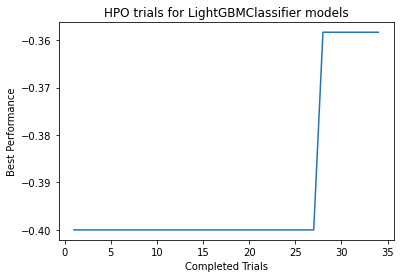

*** Details of Hyperparameter optimization ***
HPO for LightGBMClassifier model:  Num. configurations tried = 34, Time spent = 91.04652786254883, Search strategy = random
Best hyperparameter-configuration (validation-performance: accuracy = -0.35833333333333334):
{'boosting_type▁choice': 0, 'feature_fraction': 0.8697498361349312, 'learning_rate': 0.06142885606149031, 'min_data_in_leaf': 22, 'num_leaves': 47}
*** End of fit() summary ***


In [8]:
results = predictor_hpo.fit_summary()

## References

[**AutoGluon Documentation** (autogluon.mxnet.io)](https://autogluon.mxnet.io/api/autogluon.task.html)

Erickson et al. [**AutoGluon-Tabular: Robust and Accurate AutoML for Structured Data**](https://arxiv.org/abs/2003.06505). *Arxiv*, 2020.

Boehmke B, Greenwell B. [**Hands-On Machine Learning with R** (Chapters 8-13 and 15)](https://bradleyboehmke.github.io/HOML/). 2020.

Dietterich T. [**Ensemble Methods in Machine Learning**](https://web.engr.oregonstate.edu/~tgd/publications/mcs-ensembles.pdf). In: *Multiple Classifier Systems*, 2000. 

Rocca J. [**Ensemble methods: bagging, boosting and stacking**](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205). *Towards Data Science*, 2019.

Caruana et al. [**Ensemble Selection from Libraries of Models**](https://www.cs.cornell.edu/~alexn/papers/shotgun.icml04.revised.rev2.pdf). In: *ICML*, 2004.

van Veen et al. [**Kaggle Ensembling Guide**](https://mlwave.com/kaggle-ensembling-guide/). *mlwave.com*, 2015.

Breiman L. [**Bagging Predictors**](https://www.stat.berkeley.edu/~breiman/bagging.pdf). *Technical Report*, 1994.

Breiman L. [**Stacked Regressions**](https://statistics.berkeley.edu/sites/default/files/tech-reports/367.pdf). *Technical Report*, 1996.

 Wolpert, D. [**Stacked generalization**](https://www.sciencedirect.com/science/article/abs/pii/S0893608005800231). *Neural Networks*, 1992.

Van der Laan et al. [**Super Learner**](https://biostats.bepress.com/cgi/viewcontent.cgi?article=1226&context=ucbbiostat). *Stat Appl Genet Mol Biol*, 2007.

Polley E, Van der Laan, M. [**Super Learner In Prediction**](https://biostats.bepress.com/cgi/viewcontent.cgi?article=1269&context=ucbbiostat). *U.C. Berkeley Division of Biostatistics Working Paper Series*, 2010.

Koren Y. [**The BellKor Solution to the Netflix Grand Prize**](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf). *netflixprize.com*, 2009.

Titericz G, Semenov S. [**1st PLACE - WINNER SOLUTION**](https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/14335). *Kaggle Otto Group Product Classification Challenge*, 2016.

Ke et al. [**LightGBM: A Highly Efficient Gradient Boosting Decision Tree**](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf). In: *NIPS*, 2017.

Prokhorenkova et al. [**CatBoost: unbiased boosting with categorical features**](https://arxiv.org/abs/1706.09516). In: *NeurIPS*, 2018.